# Imports

In [1]:
#pip install pandas==1.3.5
#pip install cellrank --upgrade
#pip install git+https://github.com/theislab/cellrank.git@main
#pip install moscot
#pip install palantir

In [2]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np
import os, tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import celltypist
from celltypist import models
import csv
from gtfparse import read_gtf
import hdf5plugin
import seaborn as sns
import scanpy.external as sce
import anndata as ad
import seaborn as sb
import palantir
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib as mpl

In [3]:
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
#Now import hyper
import hyper
import warnings
warnings.simplefilter("ignore", category=UserWarning)
# Inline plotting
%matplotlib inline
plt.rcParams['axes.grid'] = False

In [4]:
import cellrank as cr
cr.settings.verbosity = 2
cr.logging.print_versions()

cellrank==2.0.3.dev1+gcabbd34 scanpy==1.9.6 anndata==0.10.5.post1 numpy==1.23.5 numba==0.58.1 scipy==1.11.3 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.14.0 python-igraph==0.10.4 scvelo==0.3.1 pygam==0.8.0 matplotlib==3.6.3 seaborn==0.12.2


## Figure Settings

In [5]:
# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Set figure directory
sc.settings.figdir = './figures/'
scv.settings.figdir = './figures/'

figfolder = './figures/'

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

## Custom colormap

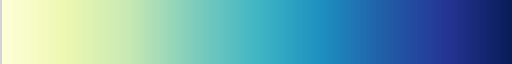

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the 'lightgrey' color as an RGBA tuple with values in the range 0-1
lightgrey_rgba = (0.83, 0.83, 0.83, 1.0)  # RGB values for lightgrey with alpha=1.0
# Get the 'YlGnBu' colormap
YlGnBu_cmap = plt.cm.get_cmap('YlGnBu')
# Define the number of steps for interpolation
num_steps = 256
# Define the range for values where lightgrey is used
lightgrey_range = 0.0
# Interpolate between light grey and blue for values from 0 to lightgrey_range
interpolated_colors_below = [lightgrey_rgba] + [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * lightgrey_range))]
# Interpolate between light grey and green for values from lightgrey_range to 1
interpolated_colors_above = [YlGnBu_cmap(i) for i in np.linspace(0, 1, int(num_steps * (1 - lightgrey_range)))]
# Combine the two sets of colors
interpolated_colors = interpolated_colors_below + interpolated_colors_above
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_YlGnBu', interpolated_colors)
# Now you can use this custom colormap in your plots
cmap

# Volcano Plot

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_volcano(dataframes, top_genes=25, logfc_cutoff=1, pval_cutoff=0.05):
    for name, df in dataframes.items():
        prefix = name.split('_')[1]

        plt.figure(figsize=(8, 6))

        plt.scatter(x=df[f'{prefix}_logfoldchanges'], 
                    y=df[f'{prefix}_pvals_adj'].apply(lambda x: -np.log10(x)), 
                    s=1, label="Not significant", color='lightgray')

        down = df[(df[f'{prefix}_logfoldchanges'] <= -logfc_cutoff) & (df[f'{prefix}_pvals_adj'] <= pval_cutoff)]
        up = df[(df[f'{prefix}_logfoldchanges'] >= logfc_cutoff) & (df[f'{prefix}_pvals_adj'] <= pval_cutoff)]

        top_downregulated = down.sort_values(by=f'{prefix}_scores', ascending=True).head(top_genes)
        top_upregulated = up.sort_values(by=f'{prefix}_scores', ascending=False).head(top_genes)
        
        max_abs_logfc = max(np.ceil(abs(top_upregulated[f'{prefix}_logfoldchanges']).max()), np.ceil(abs(top_downregulated[f'{prefix}_logfoldchanges']).max()))
        xlim=(-max_abs_logfc-2,max_abs_logfc+2)

        plt.scatter(x=down[f'{prefix}_logfoldchanges'], 
                    y=down[f'{prefix}_pvals_adj'].apply(lambda x: -np.log10(x)), 
                    s=3, label="Down-regulated", color="blue")
        plt.scatter(x=up[f'{prefix}_logfoldchanges'], 
                    y=up[f'{prefix}_pvals_adj'].apply(lambda x: -np.log10(x)), 
                    s=3, label="Up-regulated", color="red")

        plt.title(f"Volcano Plot for {name}", y=1.1)
        plt.xlabel("logFC", fontsize=18)
        plt.xlim(xlim)
        plt.ylabel("-logFDR", fontsize=18)
        plt.axvline(-logfc_cutoff, color="grey", linestyle="--")
        plt.axvline(logfc_cutoff, color="grey", linestyle="--")
        plt.axhline(-np.log10(pval_cutoff), color="grey", linestyle="--")
        plt.legend(loc='center', bbox_to_anchor=(0.5, 1.01, 0, 0.1),fontsize=14,markerscale=5,ncols=3)

        texts = []
        for i, r in top_downregulated.iterrows():
            texts.append(plt.text(x=r[f'{prefix}_logfoldchanges'], 
                                  y=-np.log10(r[f'{prefix}_pvals_adj']),
                                  s=r[f'{prefix}_names'], 
                                  fontsize=7, 
                                  fontweight='heavy',
                                  color='blue', 
                                  ha='center', 
                                  va='bottom'))

        for i, r in top_upregulated.iterrows():
            texts.append(plt.text(x=r[f'{prefix}_logfoldchanges'], 
                                  y=-np.log10(r[f'{prefix}_pvals_adj']),
                                  s=r[f'{prefix}_names'], 
                                  fontsize=7, 
                                  fontweight='heavy',
                                  color='red', 
                                  ha='center', 
                                  va='bottom'))

        adjust_text(texts, arrowprops=dict(arrowstyle='-', connectionstyle='arc3', color='k'))

        plt.savefig(f'./figures/Volcano_plot_Std_NE_exp_{name}',bbox_inches='tight')
        plt.show()

# Subset NE Expansion cells

In [46]:
adata=sc.read_h5ad('./data/NEr_fAOs_annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'AT1', 'AT2', 'Basal', 'Bud Tip Adjacent', 'Bud Tip Progenitor', 'Club-like Secretory', 'Deuterosomal', 'Goblet', 'Goblet-like Secretory', 'Ionocyte', 'Lower Airway Progenitor', 'MEC', 'Mucous', 'Multiciliated', 'PNEC', 'RAS', 'SMG Basal/Duct', 'Secretory', 'Serous', 'Suprabasal', 'Tuft', 'Unknown', 'CELLTYPIST', 'PNEC_Signature', 'CELLTYPIST_media', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CELLTYPIST_colors', 'CELLTYPIST_media_colors', 'CE

In [47]:
# Create a boolean mask based on your condition
condition_mask = (
    adata.obs['Media'].isin(['NE Expansion'])
)

adata_exp = adata[condition_mask]
cells_ID = adata_exp.obs_names
len(cells_ID)

842

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


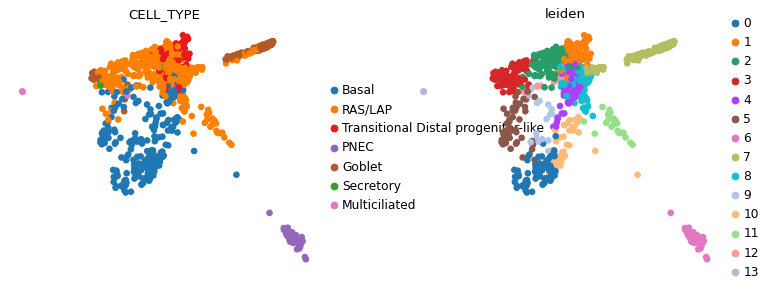

In [51]:
sc.pl.draw_graph(adata_exp,use_raw=True, color=['CELL_TYPE','leiden'])

In [52]:
adata_raw=sc.read_h5ad('./data/STARsolo.velocyto_NEr-fAOs.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 5817 × 32245
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [53]:
condition_mask = adata_raw.obs_names.isin(cells_ID)
adata_exp = adata_raw[condition_mask]
adata_exp

View of AnnData object with n_obs × n_vars = 842 × 32245
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week'
    var: 'gene_ids', 'feature_types', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [54]:
adata_NErfAOs=sc.read_h5ad('./data/NEr_fAOs_annotated.h5ad')
adata_NErfAOs.obs['CELL_TYPE']=adata_NErfAOs.obs['leiden']
adata_exp.obs['CELL_TYPE']=adata_NErfAOs.obs['CELL_TYPE']
adata_exp.obs['CELL_TYPE']=adata_NErfAOs.obs['CELL_TYPE']
adata_exp.obs

/tmp/ipykernel_71353/920670172.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_exp.obs['cluster']=adata_NErfAOs.obs['cluster']


Sample ID         Media Time point Patient ID Passage  \
s027.1        s027  NE Expansion       day0       119e     P14   
s027.2        s027  NE Expansion       day0       119e     P14   
s027.3        s027  NE Expansion       day0       119e     P14   
s027.4        s027  NE Expansion       day0       119e     P14   
s027.5        s027  NE Expansion       day0       119e     P14   
...            ...           ...        ...        ...     ...   
s001.289      s001  NE Expansion       day0       125e      P6   
s001.290      s001  NE Expansion       day0       125e      P6   
s001.291      s001  NE Expansion       day0       125e      P6   
s001.292      s001  NE Expansion       day0       125e      P6   
s001.293      s001  NE Expansion       day0       125e      P6   

         Gestational Week cluster                            CELL_TYPE  
s027.1            week_18       3                            Secretory  
s027.2            week_18       4                                Basal  
s027.3            week_18       8                              RAS/LAP  
s027.4            week_18       4                                Basal  
s027.5            week_18      11                              RAS/LAP  
...                   ...     ...                                  ...  
s001.289          week_17       1  Transitional Distal progenitor-like  
s001.290          week_17       0                                Basal  
s001.291          week_17       1                              RAS/LAP  
s001.292          week_17       2                              RAS/LAP  
s001.293          week_17       2                              RAS/LAP  

[842 rows x 8 columns]

In [55]:
sc.pp.filter_genes(adata_exp, min_cells=3)
adata_exp.var

gene_ids    feature_types  n_cells
ENSG00000268903   ENSG00000268903.1  Gene Expression       13
ENSG00000241860   ENSG00000241860.7  Gene Expression       14
ENSG00000228463  ENSG00000228463.10  Gene Expression       28
ENSG00000290385   ENSG00000290385.1  Gene Expression       15
ENSG00000230021  ENSG00000230021.10  Gene Expression       46
...                             ...              ...      ...
MT-ND6            ENSG00000198695.2  Gene Expression      297
MT-TE             ENSG00000210194.1  Gene Expression       16
MT-CYB            ENSG00000198727.2  Gene Expression      842
MT-TT             ENSG00000210195.2  Gene Expression       17
MT-TP             ENSG00000210196.2  Gene Expression       14

[21494 rows x 3 columns]

## Normalization & Highly Variable Genes

In [56]:
# Save counts layer
adata_exp.layers["counts"] = adata_exp.X.copy()

#  Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata_exp, target_sum=1e4)

#Logarithmize the data matrix.
#Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(adata_exp)

adata_exp.raw = adata_exp.copy()
adata_exp

AnnData object with n_obs × n_vars = 842 × 21494
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE'
    var: 'gene_ids', 'feature_types', 'n_cells'
    uns: 'log1p'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

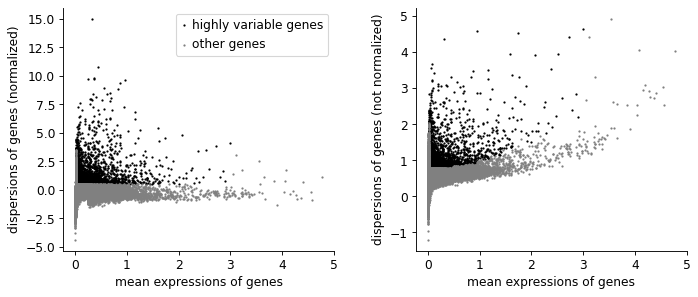

In [57]:
# highly-variable genes are selected
sc.pp.highly_variable_genes(adata_exp, layer=None, n_top_genes=None, min_disp=0.5, min_mean=0.0125,
                                max_mean=3, span=0.3, n_bins=20, flavor='seurat', 
                                subset=False, inplace=True,batch_key=None, check_values=True)
sc.pl.highly_variable_genes(adata_exp)

## Regress out (mostly) unwanted sources of variation.

In [58]:
# Parsing of Cell Cycle genes file
cell_cycle_genes = [x.strip() for x in open ('./data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_basal.var_names]

In [59]:
# Score all genes using our S and G2M phase gene lists
sc.tl.score_genes_cell_cycle(adata_exp, s_genes=s_genes, g2m_genes=g2m_genes)

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
... storing 'phase' as categorical
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


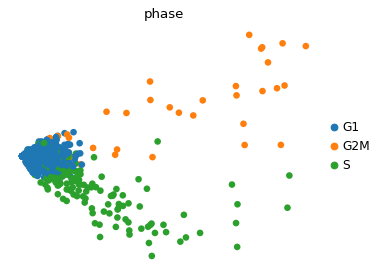

In [60]:
# We will plot the PCA of the cell cycle genes' source of variation
adata_cc_genes = adata_exp[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')

In [61]:
adata_exp.var['mt'] = adata_exp.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_exp, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_exp.var['rp'] = adata_exp.var_names.str.startswith('RP')  # annotate the group of ribosomal genes as 'rp'
sc.pp.calculate_qc_metrics(adata_exp, qc_vars=['rp'], percent_top=None, log1p=False, inplace=True)

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
... storing 'phase' as categorical


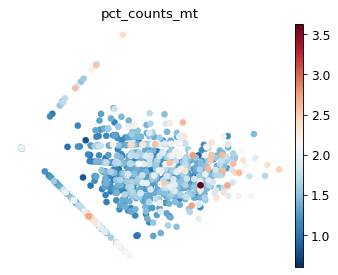

In [62]:
# We will plot the PCA of the mitochondrial genes' source of variation
adata_mt_genes = adata_exp[:, adata_exp.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
... storing 'phase' as categorical


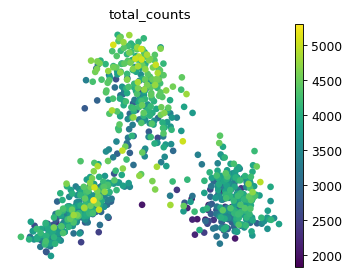

In [63]:
# We will plot the PCA of the total counts' source of variation
adata_hvg = adata_exp[:, adata_exp.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

In [64]:
# Regress out the unwanted sources of variation.
sc.pp.regress_out(adata_exp, ["total_counts", "pct_counts_mt"])

... storing 'phase' as categorical


/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


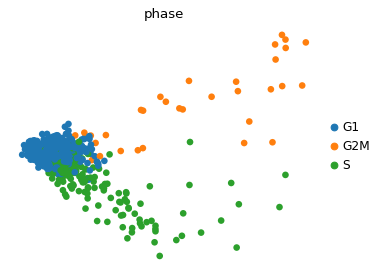

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


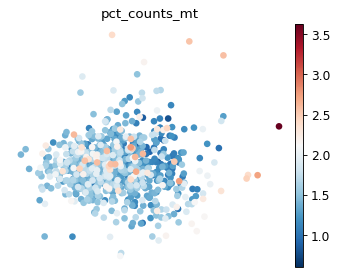

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


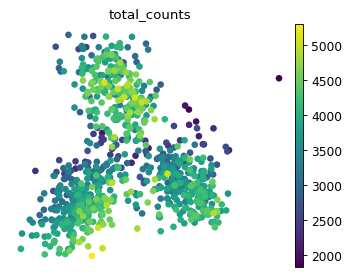

In [65]:
# Plot PCA again after regression
adata_cc_genes = adata_exp[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')
adata_mt_genes = adata_exp[:, adata_exp.var_names.str.startswith('MT-')]
sc.tl.pca(adata_mt_genes)
sc.pl.pca_scatter(adata_mt_genes, color='pct_counts_mt')
adata_hvg = adata_exp[:, adata_exp.var['highly_variable']]
sc.tl.pca(adata_hvg)
sc.pl.pca_scatter(adata_hvg, color='total_counts', cmap='viridis')

## Scaling of the data

In [66]:
# Scale data to unit variance and zero mean store results in layer
# Variables (genes) that do not display any variation (are constant across all observations) 
# are retained and set to 0 during this operation. In the future, they might be set to NaNs.

adata_exp.layers["scaled"] = sc.pp.scale(adata_exp, copy=True).X
adata_exp

AnnData object with n_obs × n_vars = 842 × 21494
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'cluster', 'CELL_TYPE', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'log1p', 'hvg'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts', 'scaled'

## Compute PCA

In [67]:
sc.tl.pca(adata_exp, n_comps=50, use_highly_variable=True, svd_solver='arpack')

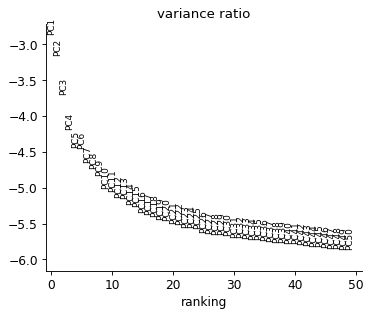

In [68]:
sc.pl.pca_variance_ratio(adata_exp, log=True,n_pcs=50)

In [69]:
sc.pp.neighbors(adata_exp, n_neighbors=30, n_pcs=25)
sc.tl.draw_graph(adata_exp)

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


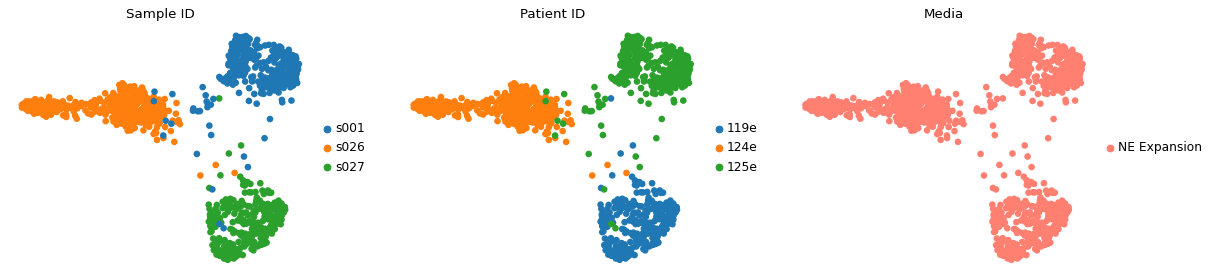

In [70]:
custom_order = ['NE Expansion']
custom_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)
adata_exp.obs['Media'] = adata_exp.obs['Media'].astype(custom_dtype)
adata_exp.uns['Media_colors']= ['#FF7F71']

sc.pl.draw_graph(adata_exp, color=['Sample ID','Patient ID','Media'],save='_NEexp_NOT_harmonized')

In [71]:
sc.external.pp.harmony_integrate(adata_exp, ['Sample ID'], basis='X_pca', adjusted_basis='X_pca_harmony')

2026-01-09 15:03:03,880 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2026-01-09 15:03:05,837 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2026-01-09 15:03:05,842 - harmonypy - INFO - Iteration 1 of 50
Iteration 1 of 50
2026-01-09 15:03:07,413 - harmonypy - INFO - Iteration 2 of 50
Iteration 2 of 50
2026-01-09 15:03:08,919 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations


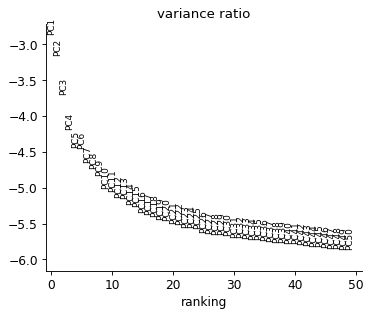

In [72]:
adata_exp.obsm['prev_X_pca'] = adata_exp.obsm['X_pca']
adata_exp.obsm['X_pca'] = adata_exp.obsm['X_pca_harmony']

sc.pl.pca_variance_ratio(adata_exp, log=True,n_pcs=50)

In [88]:
sc.pp.neighbors(adata_exp, n_neighbors=30, n_pcs=25)
sc.tl.draw_graph(adata_exp)

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


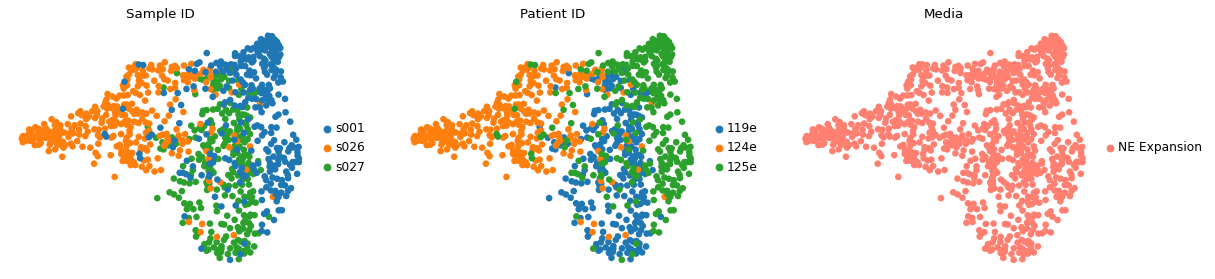

In [89]:
sc.pl.draw_graph(adata_exp, color=['Sample ID','Patient ID','Media'],save='_NEexp_harmonized')

In [90]:
adata_exp.uns['CELL_TYPE_colors']=[
 '#1f77b4', #Basal
 '#ff7f0e', #RAS/LAP
 '#d62728', #Transitional Distal
 '#9467bd', #PNEC
 '#8c564b', #Goblet
 '#2ca02c', #Secretory
 '#e377c2'  #Meulticiliated
]

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


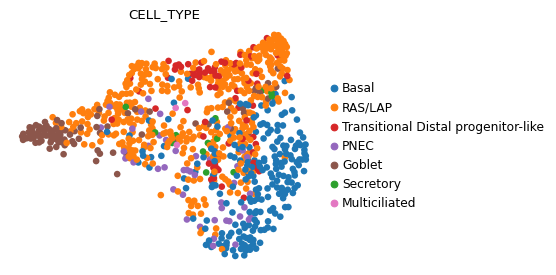

In [91]:
sc.pl.draw_graph(adata_exp, color=['CELL_TYPE'],save='_NEexp_harmonized')

In [92]:
adata_exp.write_h5ad('./data/NE_Exp_annotated.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# Velocity

In [93]:
scVelo_adata=sc.read_h5ad('./data/NE_Exp_annotated.h5ad')
columns_to_keep = ['Sample ID', 'Media', 'Time point', 'Patient ID', 'n_genes_by_counts', 'total_counts',
                   'total_counts_mt', 'total_counts_rp', 'pct_counts_rp','pct_counts_mt', 'phase',
                   'CELL_TYPE','CELL_TYPE', 'leiden','CELL_TYPE']
columns_to_remove = [column for column in scVelo_adata.obs.columns if column not in columns_to_keep]
scVelo_adata.obs = scVelo_adata.obs.drop(columns=columns_to_remove)
scVelo_adata

AnnData object with n_obs × n_vars = 842 × 21494
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp'
    uns: 'CELL_TYPE_colors', 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'prev_X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'scaled', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

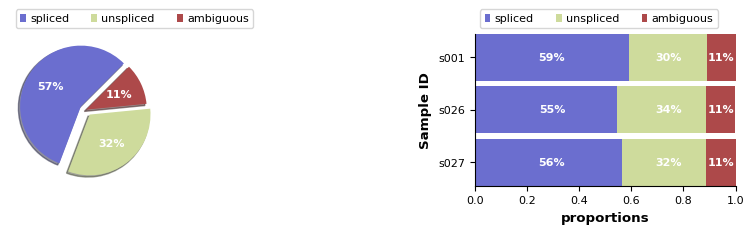

In [94]:
scv.pl.proportions(scVelo_adata,groupby='Sample ID')

In [95]:
scv.pp.moments(scVelo_adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [96]:
scv.tl.recover_dynamics(scVelo_adata)

recovering dynamics (using 1/128 cores)


  0%|          | 0/206 [00:00<?, ?gene/s]

    finished (0:01:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [97]:
scv.tl.velocity(scVelo_adata, mode="stochastic")

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [98]:
scv.tl.velocity_graph(scVelo_adata)

computing velocity graph (using 1/128 cores)


  0%|          | 0/842 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo__draw_graph_fa_NEexp_cceltyp.pdf


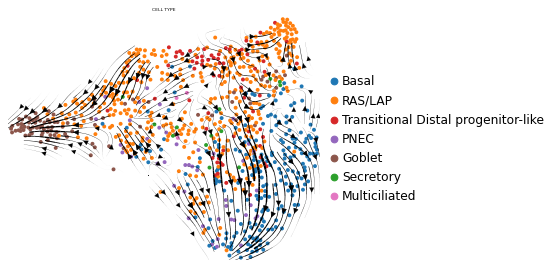

In [99]:
scv.pl.velocity_embedding_stream(scVelo_adata, 
                                basis = 'draw_graph_fa', 
                                color=['CELL_TYPE'],
                                size=50,
                                alpha=1,
                                linecolor='k',
                                linewidth=1,
                                smooth=1, 
                                min_mass=3,
                                frameon=False,
                                colorbar=True,
                                fontsize=4,
                                legend_loc='right margin',
                                save='_draw_graph_fa_NEexp_cceltyp')

In [100]:
scVelo_adata.write_h5ad('./data/NE_Exp_scVelo.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

# CellRank - Velocity Kernel - FORWARD

In [102]:
adata=sc.read_h5ad('./data/NE_Exp_scVelo.h5ad')
adata.obs

Sample ID         Media Time point Patient ID cluster  \
s027.1        s027  NE Expansion       day0       119e       3   
s027.2        s027  NE Expansion       day0       119e       4   
s027.3        s027  NE Expansion       day0       119e       8   
s027.4        s027  NE Expansion       day0       119e       4   
s027.5        s027  NE Expansion       day0       119e      11   
...            ...           ...        ...        ...     ...   
s001.289      s001  NE Expansion       day0       125e       1   
s001.290      s001  NE Expansion       day0       125e       0   
s001.291      s001  NE Expansion       day0       125e       1   
s001.292      s001  NE Expansion       day0       125e       2   
s001.293      s001  NE Expansion       day0       125e       2   

                                    CELL_TYPE phase  n_genes_by_counts  \
s027.1                              Secretory    G1               4606   
s027.2                                  Basal    G1               3507   
s027.3                                RAS/LAP    G1               4300   
s027.4                                  Basal    G1               5864   
s027.5                                RAS/LAP    G1               3646   
...                                       ...   ...                ...   
s001.289  Transitional Distal progenitor-like    G1               3274   
s001.290                                Basal    G1               4881   
s001.291                              RAS/LAP    G1               2412   
s001.292                              RAS/LAP    G1               3780   
s001.293                              RAS/LAP    G1               2440   

          total_counts  total_counts_mt  pct_counts_mt  total_counts_rp  \
s027.1     4235.992188        52.875038       1.248233       219.114334   
s027.2     4112.001953        59.340874       1.443114       217.143936   
s027.3     4314.564453        47.708035       1.105744       207.659988   
s027.4     4747.362305        48.184883       1.014982       207.531235   
s027.5     4030.138672        51.277763       1.272357       225.499985   
...                ...              ...            ...              ...   
s001.289   3905.757324        54.767448       1.402224       228.520386   
s001.290   4209.497559        55.271832       1.313027       278.327423   
s001.291   3267.999512        54.624969       1.671511       250.558533   
s001.292   3984.413574        54.284229       1.362415       244.332840   
s001.293   3362.160889        50.497795       1.501945       246.094604   

          pct_counts_rp  n_counts  velocity_self_transition  
s027.1         5.172680 -0.000014                  0.300335  
s027.2         5.280735  0.000130                  0.325749  
s027.3         4.813000  0.000302                  0.257536  
s027.4         4.371506  0.000042                  0.016918  
s027.5         5.595341 -0.000212                  0.345681  
...                 ...       ...                       ...  
s001.289       5.850860 -0.000244                  0.060030  
s001.290       6.611892  0.000269                  0.551480  
s001.291       7.667031  0.000278                  0.000000  
s001.292       6.132216  0.000103                  0.194193  
s001.293       7.319537 -0.000168                  0.063790  

[842 rows x 15 columns]

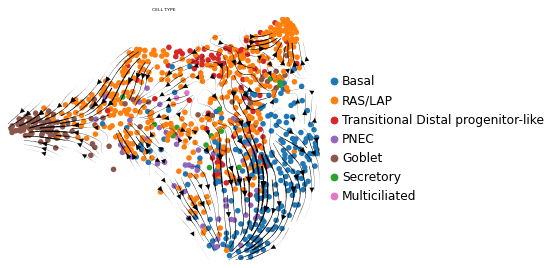

In [106]:
scv.pl.velocity_embedding_stream(adata, 
                                basis = 'draw_graph_fa', 
                                color=['CELL_TYPE'],
                                size=100,
                                alpha=1,
                                linecolor='k',
                                linewidth=1,
                                smooth=0.9, 
                                min_mass=3,
                                frameon=False,
                                colorbar=True,
                                title=['CELL_TYPE'],
                                fontsize=4,
                                legend_loc='right margin')

In [107]:
vk_fwd = cr.kernels.VelocityKernel(adata,backward=False)

In [108]:
vk_fwd.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/842 [00:00<?, ?cell/s]

Using `softmax_scale=10.4513`


  0%|          | 0/842 [00:00<?, ?cell/s]

    Finish (0:00:02)


VelocityKernel[n=842, model='deterministic', similarity='correlation', softmax_scale=10.451]

Projecting transition matrix onto `draw_graph_fa`
Adding `adata.obsm['T_fwd_draw_graph_fa']`
    Finish (0:00:00)
figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file ./figures/scvelo_cellrank_vk_NEexp_FORWARDprojection_fdl.png


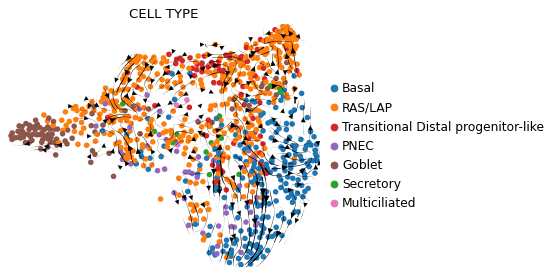

Simulating `100` random walks of maximum length `200`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks


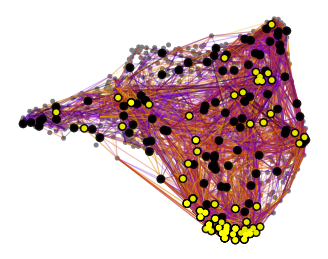

In [110]:
vk_fwd.plot_projection(basis='draw_graph_fa', color=['CELL_TYPE'], legend_loc='right margin',
                   size=100, alpha=1,save='cellrank_vk_NEexp_FORWARDprojection_fdl')
vk_fwd.plot_random_walks(basis="draw_graph_fa",start_ixs=None, max_iter=200, seed=0,save='cellrank_vk_NEexp_FORWARDrandomwalk_fdl')

In [111]:
vk_fwd.write_to_adata()
adata.write('./data/NEexp_cellrank_vk.h5ad')
adata

AnnData object with n_obs × n_vars = 842 × 21494
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'n_counts', 'velocity_self_transition'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'CELL_TYPE_colors', 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'draw_graph', 'hvg', 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_pa

In [112]:
vk_fwd = cr.kernels.VelocityKernel.from_adata(adata, key="T_fwd")

In [113]:
from cellrank.estimators import GPCCA

In [114]:
g = cr.estimators.GPCCA(vk_fwd)
print(g)

GPCCA[kernel=VelocityKernel[n=842], initial_states=None, terminal_states=None]


Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 7, 12, 15, 17, 19]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:11)


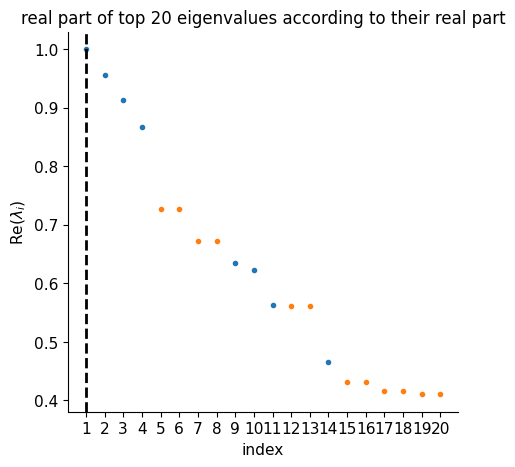

In [115]:
g.compute_schur(method='brandts')
g.plot_spectrum(real_only=True)

In [118]:
g.fit(n_cells=15, cluster_key='CELL_TYPE', n_states=3)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:11)
Computing `3` macrostates


Using pre-computed Schur decomposition


Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


GPCCA[kernel=VelocityKernel[n=842], initial_states=None, terminal_states=None]

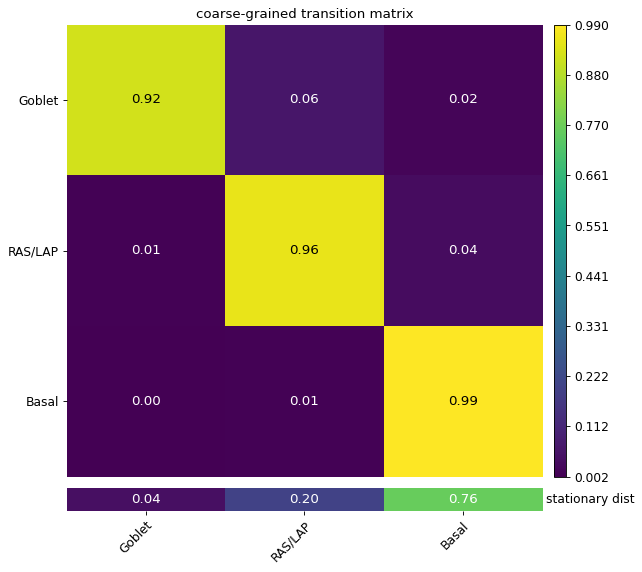

In [119]:
g.plot_coarse_T(save='cellrank_vk_NEexp_FORWARD_Tmatrix')

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_draw_graph_NEexp_FORWARD_macrostates.pdf


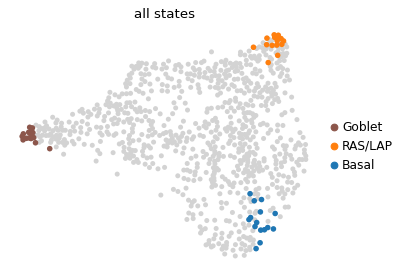

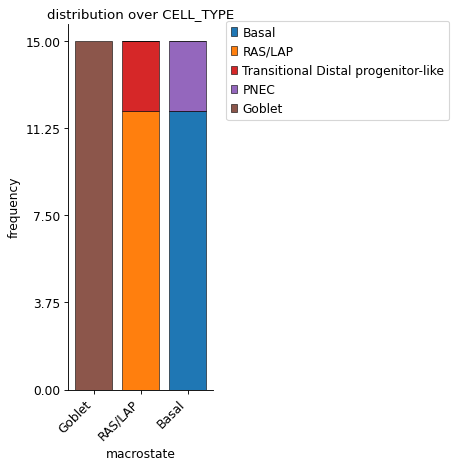

In [120]:
g.plot_macrostates(which="all",basis=["draw_graph_fa"], discrete=True, 
                   legend_loc="right", s=100,save='draw_graph_NEexp_FORWARD_macrostates')
g.plot_macrostate_composition(key="CELL_TYPE", figsize=(6, 6),save='cellrank_NEexp_FORWARD_macrostates_distr')

In [121]:
g.predict_terminal_states()

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


GPCCA[kernel=VelocityKernel[n=842], initial_states=None, terminal_states=['Basal']]

In [122]:
adata.obs['term_states_fwd_probs']

s027.1      0.153185
s027.2      0.412868
s027.3      0.419913
s027.4      0.996031
s027.5      0.958073
              ...   
s001.289    0.224381
s001.290    0.274208
s001.291    0.121114
s001.292    0.156185
s001.293    0.186138
Name: term_states_fwd_probs, Length: 842, dtype: float64

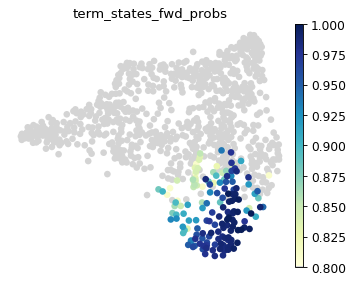

In [123]:
sc.pl.draw_graph(adata, color='term_states_fwd_probs',cmap=cmap,vmin=0.8,save='NEexp_term_states_fwd_probs')

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_all_terminalstates_draw_graph.pdf


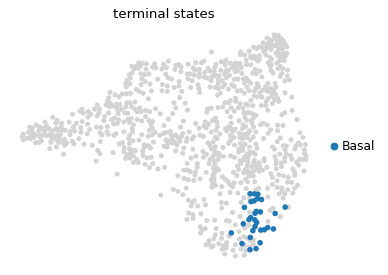

In [124]:
g.plot_macrostates(which="terminal",basis=["draw_graph_fa"], legend_loc="right", s=100, 
                   save='NEexp_all_terminalstates_draw_graph')

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_n2_terminalstates_draw_graph.pdf


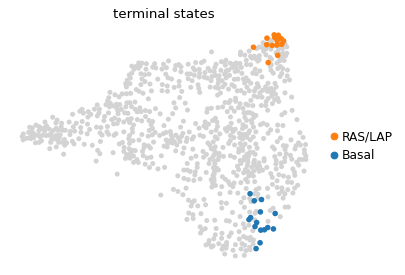

In [125]:
g.predict_terminal_states(method='top_n',n_states=2, n_cells=15, allow_overlap=True)
g.plot_macrostates(which="terminal",basis=["draw_graph_fa"], legend_loc="right", s=100,
                   save='NEexp_n2_terminalstates_draw_graph')

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_n1_terminalstates_draw_graph.pdf


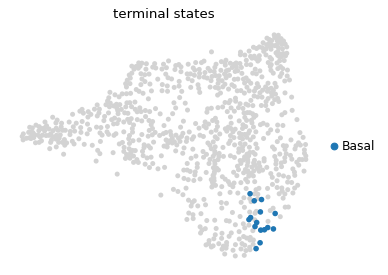

In [126]:
g.predict_terminal_states(method='top_n',n_states=1, n_cells=15, allow_overlap=True)
g.plot_macrostates(which="terminal",basis=["draw_graph_fa"], legend_loc="right", s=100,
                   save='NEexp_n1_terminalstates_draw_graph')

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_stability_terminalstates_draw_graph.pdf


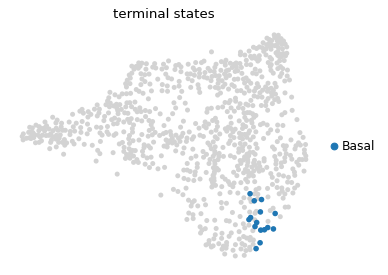

In [127]:
g.predict_terminal_states(method='stability', n_cells=15, allow_overlap=True)
g.plot_macrostates(which="terminal",basis=["draw_graph_fa"], legend_loc="right", s=100,
                   save='NEexp_stability_terminalstates_draw_graph')

In [128]:
g.predict_initial_states(n_cells=15, allow_overlap=True)

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


GPCCA[kernel=VelocityKernel[n=842], initial_states=['Goblet'], terminal_states=['Basal']]

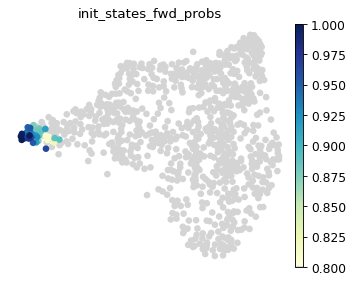

In [129]:
sc.pl.draw_graph(adata, color='init_states_fwd_probs',cmap=cmap,vmin=0.8,save='NEexp_init_states_fwd_probs')

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_all_initialstates_draw_graph.pdf


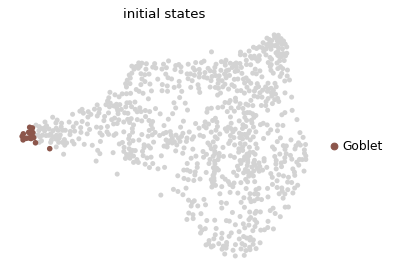

In [130]:
g.plot_macrostates(which="initial",basis=["draw_graph_fa"], legend_loc="right", s=100, 
                   save='NEexp_all_initialstates_draw_graph')

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_n1_initialstates_draw_graph.pdf


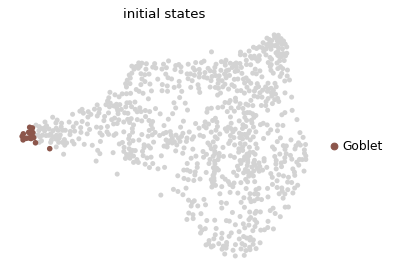

In [131]:
g.predict_initial_states(n_states=1, n_cells=15, allow_overlap=True)
g.plot_macrostates(which="initial",basis=["draw_graph_fa"], legend_loc="right", s=100,
                   save='NEexp_n1_initialstates_draw_graph')

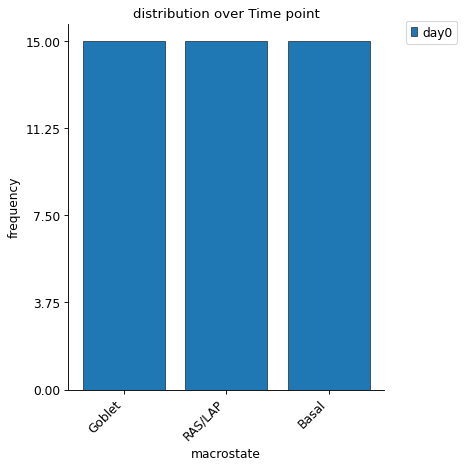

In [132]:
g.plot_macrostate_composition(key="Time point", figsize=(6, 6),save='NEexp_all_initialstates_FORWARD_macrostates_timepoint')

In [133]:
g.write('./data/NEexp_cellrank_gpcca_FWD.h5ad', write_adata=True)
adata.write('./data/NEexp_cellrank_vk.h5ad')

Writing `GPCCA[kernel=VelocityKernel[n=842], initial_states=['Goblet'], terminal_states=['Basal']]` to `./data/NEexp_cellrank_gpcca_FWD.h5ad`


In [134]:
adata

AnnData object with n_obs × n_vars = 842 × 21494
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'n_counts', 'velocity_self_transition', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'init_states_fwd', 'init_states_fwd_probs'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'CELL_TYPE_colors', 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'draw_graph', '

## Cell Rank - Estimating Fate Probabilities and Driver Genes

In [135]:
vk_fwd = cr.kernels.VelocityKernel.from_adata(adata, key="T_fwd")
g.read('./data/NEexp_cellrank_gpcca_FWD.h5ad', adata=adata)

GPCCA[kernel=VelocityKernel[n=842], initial_states=['Goblet'], terminal_states=['Basal']]

In [136]:
adata

AnnData object with n_obs × n_vars = 842 × 21494
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'n_counts', 'velocity_self_transition', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'init_states_fwd', 'init_states_fwd_probs'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'CELL_TYPE_colors', 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'draw_graph', '

In [137]:
g.compute_fate_probabilities()

Computing fate probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/1 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


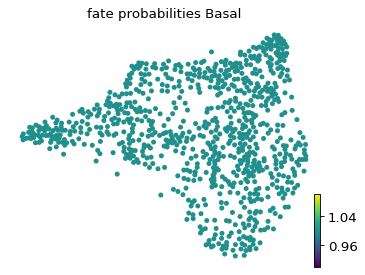

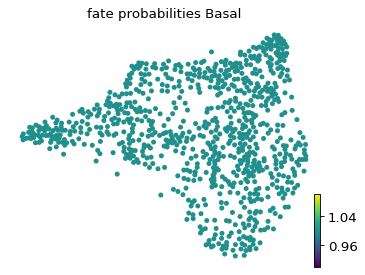

In [138]:
g.plot_fate_probabilities(basis="draw_graph_fa", same_plot=False)
g.plot_fate_probabilities(basis="draw_graph_fa", same_plot=True)

In [139]:
NEUROD1_df = g.compute_lineage_drivers(
    lineages=["NEUROD1ʰⁱᵍʰ"], CELL_TYPE_key="CELL_TYPE")
NEUROD1_df.head(20)

RuntimeError: No stationary distribution found in `.eigendecomposition['stationary_dist']`.

In [ ]:
TF_list = pd.read_csv('./data/allTFs_hg38.txt', sep="\t", header=None)[0].tolist()

In [ ]:
NEUROD1_df_TFs = NEUROD1_df[NEUROD1_df.index.isin(TF_list)]
NEUROD1_df_TFs.head(20)

In [ ]:
adata.obs["fate_probabilities_NEUROD1ʰⁱᵍʰ"] = g.fate_probabilities["NEUROD1ʰⁱᵍʰ"].X.flatten()

sc.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color=["fate_probabilities_NEUROD1ʰⁱᵍʰ"],
    color_map=cmap,
    ncols=4,
    vmax="p96",
    save='fate_probabilities_NEUROD1ʰⁱᵍʰ'
)

sc.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color= list(NEUROD1_df.index[:12]),
    color_map=cmap,
    vmin=0,
    ncols=4,
    vmax="p96",
    save='_lineage_drivers_NEUROD1ʰⁱᵍʰ'
)

sc.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color= list(NEUROD1_df_TFs.index[:12]),
    color_map=cmap,
    vmin=0,
    ncols=4,
    vmax="p96",
    save='_lineage_drivers_TFs_NEUROD1ʰⁱᵍʰ'
)

In [44]:
CALCA_df = g.compute_lineage_drivers(
    lineages=["CALCAʰⁱᵍʰ"], CELL_TYPE_key="CELL_TYPE")
CALCA_df.head(20)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


CALCAʰⁱᵍʰ_corr  CALCAʰⁱᵍʰ_pval  CALCAʰⁱᵍʰ_qval  CALCAʰⁱᵍʰ_ci_low  \
PHLDA1          0.463600    3.467895e-27    1.676346e-24          0.389151   
SLC26A9         0.410537    6.165724e-21    1.970943e-18          0.332085   
ETS2            0.398175    1.199606e-19    3.087660e-17          0.318872   
TPT1            0.397140    1.528706e-19    3.835117e-17          0.317768   
ELF3            0.380630    6.459377e-18    1.347562e-15          0.300172   
SERPINF1        0.377065    1.407193e-17    2.845831e-15          0.296380   
CADM1           0.365542    1.625184e-16    3.038634e-14          0.284140   
KRT18           0.361938    3.418316e-16    6.048894e-14          0.280318   
RPS6            0.355584    1.237752e-15    2.096667e-13          0.273584   
SLC1A5          0.343508    1.312317e-14    2.000678e-12          0.260810   
KRT8            0.333572    8.446885e-14    1.204380e-11          0.250321   
KRT7            0.333363    8.779139e-14    1.242813e-11          0.250100   
SCNN1A          0.327338    2.620926e-13    3.440009e-11          0.243749   
CD9             0.324250    4.545359e-13    5.737865e-11          0.240498   
ST6GAL1         0.319196    1.103505e-12    1.317492e-10          0.235179   
LDHB            0.318367    1.274391e-12    1.503402e-10          0.234306   
KRT19           0.315942    1.935355e-12    2.230046e-10          0.231757   
HSP90B1         0.314656    2.411797e-12    2.747092e-10          0.230405   
ATP1B1          0.312155    3.687834e-12    4.106134e-10          0.227778   
LARGE2          0.311736    3.958092e-12    4.382426e-10          0.227338   

          CALCAʰⁱᵍʰ_ci_high  
PHLDA1             0.532031  
SLC26A9            0.483348  
ETS2               0.471942  
TPT1               0.470986  
ELF3               0.455710  
SERPINF1           0.452406  
CADM1              0.441711  
KRT18              0.438362  
RPS6               0.432452  
SLC1A5             0.421201  
KRT8               0.411927  
KRT7               0.411731  
SCNN1A             0.406099  
CD9                0.403211  
ST6GAL1            0.398479  
LDHB               0.397701  
KRT19              0.395430  
HSP90B1            0.394224  
ATP1B1             0.391880  
LARGE2             0.391487

In [45]:
CALCA_df_TFs = CALCA_df[CALCA_df.index.isin(TF_list)]
CALCA_df_TFs.head(20)

CALCAʰⁱᵍʰ_corr  CALCAʰⁱᵍʰ_pval  CALCAʰⁱᵍʰ_qval  CALCAʰⁱᵍʰ_ci_low  \
ETS2           0.398175    1.199606e-19    3.087660e-17          0.318872   
ELF3           0.380630    6.459377e-18    1.347562e-15          0.300172   
TCF7L1         0.287026    2.089907e-10    1.816661e-08          0.201442   
ENO1           0.285591    2.599579e-10    2.230348e-08          0.199942   
SOX21          0.279632    6.345816e-10    5.133377e-08          0.193717   
EHF            0.255396    1.911147e-08    1.258373e-06          0.168468   
RPL35          0.253182    2.563221e-08    1.649366e-06          0.166167   
EEF1D          0.240087    1.372448e-07    7.640601e-06          0.152578   
CEBPD          0.231096    4.104254e-07    2.043774e-05          0.143267   
SOX13          0.225682    7.766255e-07    3.587865e-05          0.137668   
TFCP2L1        0.223209    1.033668e-06    4.603653e-05          0.135112   
TGIF1          0.222352    1.140411e-06    5.033808e-05          0.134227   
MYCL           0.210710    4.166920e-06    1.591217e-04          0.122213   
ZBTB7C         0.207866    5.655166e-06    2.079401e-04          0.119282   
SMARCC1        0.206877    6.282725e-06    2.293137e-04          0.118263   
TCF7L2         0.206158    6.779472e-06    2.448255e-04          0.117523   
ID2            0.205485    7.279155e-06    2.613507e-04          0.116829   
CYB5R1         0.204437    8.126303e-06    2.891476e-04          0.115750   
REST           0.203821    8.667273e-06    3.051096e-04          0.115116   
ELF5           0.203367    9.088359e-06    3.171165e-04          0.114648   

         CALCAʰⁱᵍʰ_ci_high  
ETS2              0.471942  
ELF3              0.455710  
TCF7L1            0.368261  
ENO1              0.366909  
SOX21             0.361291  
EHF               0.338382  
RPL35             0.336284  
EEF1D             0.323860  
CEBPD             0.315313  
SOX13             0.310160  
TFCP2L1           0.307804  
TGIF1             0.306988  
MYCL              0.295883  
ZBTB7C            0.293167  
SMARCC1           0.292222  
TCF7L2            0.291535  
ID2               0.290891  
CYB5R1            0.289890  
REST              0.289301  
ELF5              0.288867

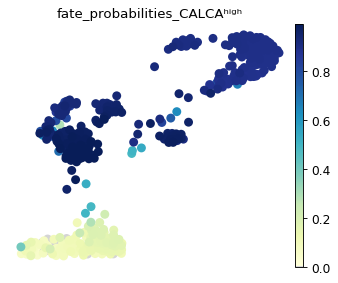

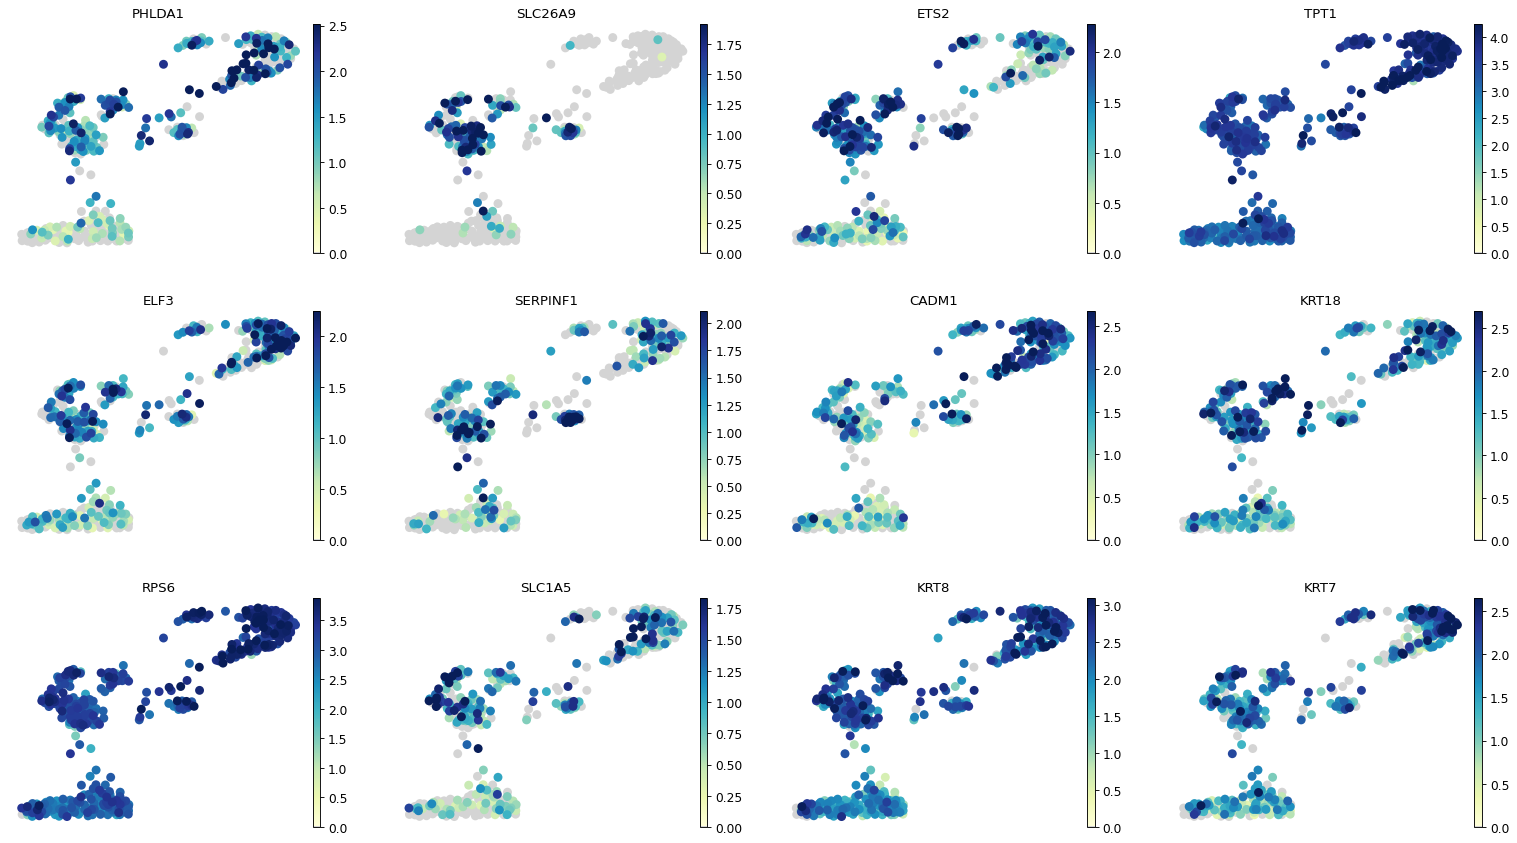

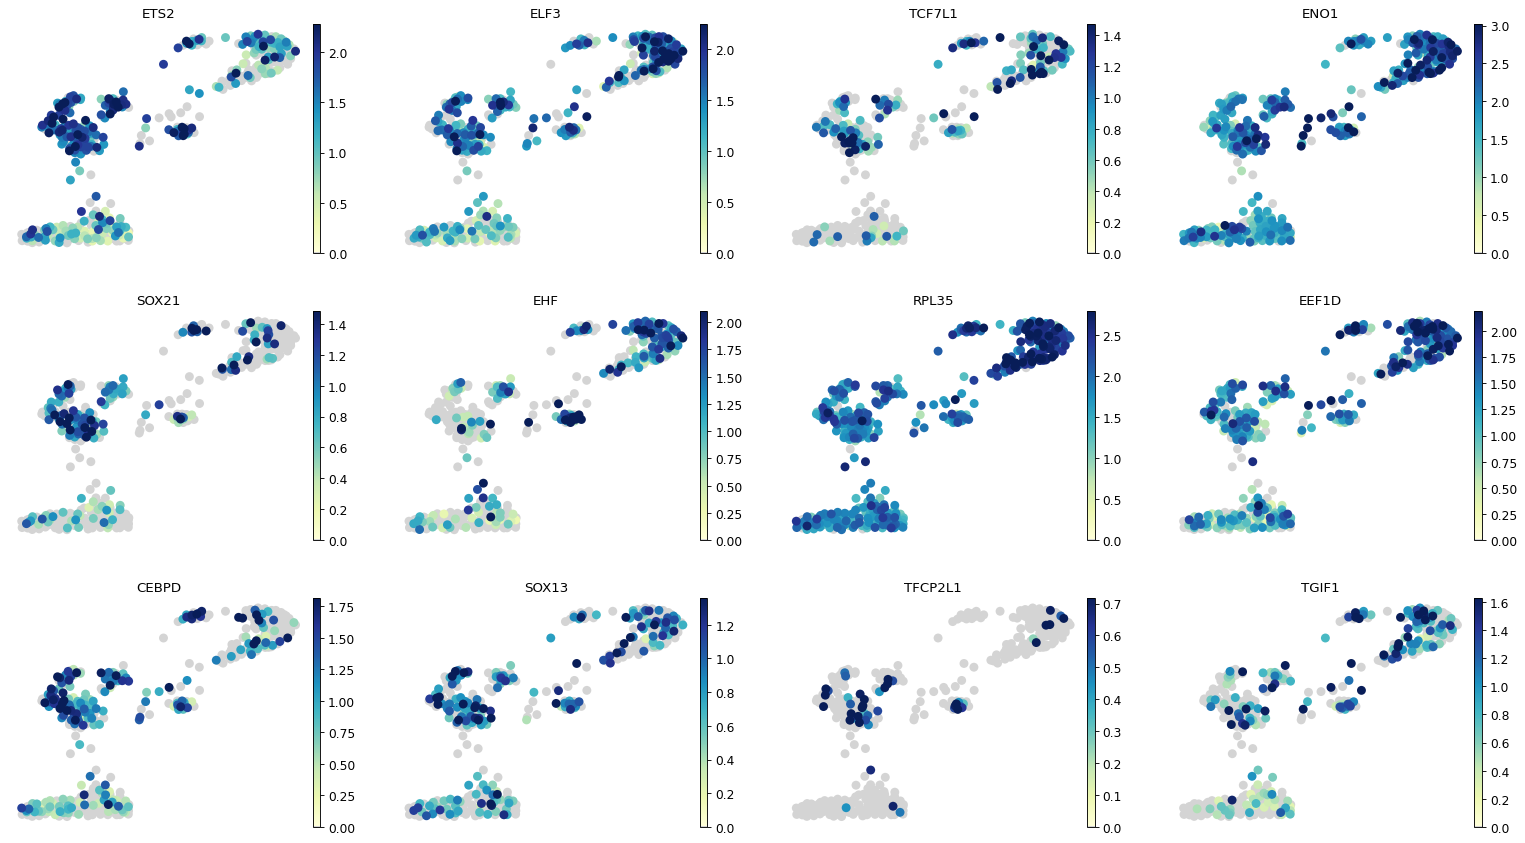

In [46]:
adata.obs["fate_probabilities_CALCAʰⁱᵍʰ"] = g.fate_probabilities["CALCAʰⁱᵍʰ"].X.flatten()

sc.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color=["fate_probabilities_CALCAʰⁱᵍʰ"],
    color_map=cmap,
    ncols=4,
    vmax="p96",
    save='fate_probabilities_CALCAʰⁱᵍʰ'
)

sc.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color= list(CALCA_df.index[:12]),
    color_map=cmap,
    vmin=0,
    ncols=4,
    vmax="p96",
    save='_lineage_drivers_CALCAʰⁱᵍʰ'
)

sc.pl.embedding(
    adata,
    basis="draw_graph_fa",
    color= list(CALCA_df_TFs.index[:12]),
    color_map=cmap,
    vmin=0,
    ncols=4,
    vmax="p96",
    save='_lineage_drivers_TFs_CALCAʰⁱᵍʰ'
)

In [47]:
# compute driver genes
driver_df = g.compute_lineage_drivers()
driver_df

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


CALCAʰⁱᵍʰ_corr  CALCAʰⁱᵍʰ_pval  CALCAʰⁱᵍʰ_qval  CALCAʰⁱᵍʰ_ci_low  \
PHLDA1         0.463600    3.467895e-27    1.676346e-24          0.389151   
SLC26A9        0.410537    6.165724e-21    1.970943e-18          0.332085   
ETS2           0.398175    1.199606e-19    3.087660e-17          0.318872   
TPT1           0.397140    1.528706e-19    3.835117e-17          0.317768   
ELF3           0.380630    6.459377e-18    1.347562e-15          0.300172   
...                 ...             ...             ...               ...   
NEUROG3       -0.640791    4.895175e-60    1.940349e-56         -0.691384   
KCTD12        -0.715620    2.686324e-83    1.331006e-79         -0.757233   
AMPH          -0.733200    3.873060e-90    2.558672e-86         -0.772581   
CADPS         -0.745727    1.982153e-95    1.964215e-91         -0.783491   
NEUROD1       -0.852363   4.468346e-163   8.855815e-159         -0.875419   

         CALCAʰⁱᵍʰ_ci_high  NEUROD1ʰⁱᵍʰ_corr  NEUROD1ʰⁱᵍʰ_pval  \
PHLDA1            0.532031         -0.463600      3.467762e-27   
SLC26A9           0.483348         -0.410537      6.165906e-21   
ETS2              0.471942         -0.398175      1.199627e-19   
TPT1              0.470986         -0.397140      1.528654e-19   
ELF3              0.455710         -0.380630      6.459428e-18   
...                    ...               ...               ...   
NEUROG3          -0.583944          0.640791      4.895465e-60   
KCTD12           -0.668221          0.715620      2.686331e-83   
AMPH             -0.688198          0.733200      3.873027e-90   
CADPS            -0.702476          0.745727      1.982175e-95   
NEUROD1          -0.825436          0.852363     4.468459e-163   

         NEUROD1ʰⁱᵍʰ_qval  NEUROD1ʰⁱᵍʰ_ci_low  NEUROD1ʰⁱᵍʰ_ci_high  
PHLDA1       1.676282e-24           -0.532031            -0.389151  
SLC26A9      1.971002e-18           -0.483348            -0.332085  
ETS2         3.087714e-17           -0.471942            -0.318872  
TPT1         3.834987e-17           -0.470986            -0.317768  
ELF3         1.347573e-15           -0.455710            -0.300172  
...                   ...                 ...                  ...  
NEUROG3      1.940464e-56            0.583944             0.691384  
KCTD12       1.331010e-79            0.668221             0.757233  
AMPH         2.558651e-86            0.688198             0.772581  
CADPS        1.964236e-91            0.702476             0.783491  
NEUROD1     8.856039e-159            0.825436             0.875419  

[19819 rows x 10 columns]

In [48]:
driver_df_TFs = driver_df[driver_df.index.isin(TF_list)]
driver_df_TFs

CALCAʰⁱᵍʰ_corr  CALCAʰⁱᵍʰ_pval  CALCAʰⁱᵍʰ_qval  CALCAʰⁱᵍʰ_ci_low  \
ETS2           0.398175    1.199606e-19    3.087660e-17          0.318872   
ELF3           0.380630    6.459377e-18    1.347562e-15          0.300172   
TCF7L1         0.287026    2.089907e-10    1.816661e-08          0.201442   
ENO1           0.285591    2.599579e-10    2.230348e-08          0.199942   
SOX21          0.279632    6.345816e-10    5.133377e-08          0.193717   
...                 ...             ...             ...               ...   
NHLH1         -0.525333    3.536673e-36    3.541790e-33         -0.588106   
SETBP1        -0.532275    2.518862e-37    2.773407e-34         -0.594374   
NKX2-2        -0.613854    2.008684e-53    4.423345e-50         -0.667472   
NEUROG3       -0.640791    4.895175e-60    1.940349e-56         -0.691384   
NEUROD1       -0.852363   4.468346e-163   8.855815e-159         -0.875419   

         CALCAʰⁱᵍʰ_ci_high  NEUROD1ʰⁱᵍʰ_corr  NEUROD1ʰⁱᵍʰ_pval  \
ETS2              0.471942         -0.398175      1.199627e-19   
ELF3              0.455710         -0.380630      6.459428e-18   
TCF7L1            0.368261         -0.287026      2.089910e-10   
ENO1              0.366909         -0.285591      2.599598e-10   
SOX21             0.361291         -0.279632      6.345873e-10   
...                    ...               ...               ...   
NHLH1            -0.456270          0.525333      3.536833e-36   
SETBP1           -0.463867          0.532275      2.518855e-37   
NKX2-2           -0.553904          0.613854      2.008638e-53   
NEUROG3          -0.583944          0.640791      4.895465e-60   
NEUROD1          -0.825436          0.852363     4.468459e-163   

         NEUROD1ʰⁱᵍʰ_qval  NEUROD1ʰⁱᵍʰ_ci_low  NEUROD1ʰⁱᵍʰ_ci_high  
ETS2         3.087714e-17           -0.471942            -0.318872  
ELF3         1.347573e-15           -0.455710            -0.300172  
TCF7L1       1.816664e-08           -0.368261            -0.201442  
ENO1         2.230365e-08           -0.366909            -0.199942  
SOX21        5.133423e-08           -0.361291            -0.193716  
...                   ...                 ...                  ...  
NHLH1        3.541852e-33            0.456270             0.588106  
SETBP1       2.773399e-34            0.463867             0.594374  
NKX2-2       4.423244e-50            0.553904             0.667472  
NEUROG3      1.940464e-56            0.583944             0.691384  
NEUROD1     8.856039e-159            0.825436             0.875419  

[1403 rows x 10 columns]

In [53]:
volcano_driver_df=driver_df_TFs
volcano_driver_df['CALCAʰⁱᵍʰ_corr-log10_FDR'] = -np.log(volcano_driver_df['CALCAʰⁱᵍʰ_qval'])
volcano_driver_df['NEUROD1ʰⁱᵍʰ_corr-log10_FDR'] = -np.log(volcano_driver_df['NEUROD1ʰⁱᵍʰ_qval'])
volcano_driver_df

CALCAʰⁱᵍʰ_corr  CALCAʰⁱᵍʰ_pval  CALCAʰⁱᵍʰ_qval  CALCAʰⁱᵍʰ_ci_low  \
ETS2           0.398175    1.199606e-19    3.087660e-17          0.318872   
ELF3           0.380630    6.459377e-18    1.347562e-15          0.300172   
TCF7L1         0.287026    2.089907e-10    1.816661e-08          0.201442   
ENO1           0.285591    2.599579e-10    2.230348e-08          0.199942   
SOX21          0.279632    6.345816e-10    5.133377e-08          0.193717   
...                 ...             ...             ...               ...   
NHLH1         -0.525333    3.536673e-36    3.541790e-33         -0.588106   
SETBP1        -0.532275    2.518862e-37    2.773407e-34         -0.594374   
NKX2-2        -0.613854    2.008684e-53    4.423345e-50         -0.667472   
NEUROG3       -0.640791    4.895175e-60    1.940349e-56         -0.691384   
NEUROD1       -0.852363   4.468346e-163   8.855815e-159         -0.875419   

         CALCAʰⁱᵍʰ_ci_high  NEUROD1ʰⁱᵍʰ_corr  NEUROD1ʰⁱᵍʰ_pval  \
ETS2              0.471942         -0.398175      1.199627e-19   
ELF3              0.455710         -0.380630      6.459428e-18   
TCF7L1            0.368261         -0.287026      2.089910e-10   
ENO1              0.366909         -0.285591      2.599598e-10   
SOX21             0.361291         -0.279632      6.345873e-10   
...                    ...               ...               ...   
NHLH1            -0.456270          0.525333      3.536833e-36   
SETBP1           -0.463867          0.532275      2.518855e-37   
NKX2-2           -0.553904          0.613854      2.008638e-53   
NEUROG3          -0.583944          0.640791      4.895465e-60   
NEUROD1          -0.825436          0.852363     4.468459e-163   

         NEUROD1ʰⁱᵍʰ_qval  NEUROD1ʰⁱᵍʰ_ci_low  NEUROD1ʰⁱᵍʰ_ci_high  \
ETS2         3.087714e-17           -0.471942            -0.318872   
ELF3         1.347573e-15           -0.455710            -0.300172   
TCF7L1       1.816664e-08           -0.368261            -0.201442   
ENO1         2.230365e-08           -0.366909            -0.199942   
SOX21        5.133423e-08           -0.361291            -0.193716   
...                   ...                 ...                  ...   
NHLH1        3.541852e-33            0.456270             0.588106   
SETBP1       2.773399e-34            0.463867             0.594374   
NKX2-2       4.423244e-50            0.553904             0.667472   
NEUROG3      1.940464e-56            0.583944             0.691384   
NEUROD1     8.856039e-159            0.825436             0.875419   

         CALCAʰⁱᵍʰ_corr-log10_FDR  NEUROD1ʰⁱᵍʰ_corr-log10_FDR  
ETS2                    38.016533                   38.016516  
ELF3                    34.240479                   34.240471  
TCF7L1                  17.823681                   17.823679  
ENO1                    17.618523                   17.618515  
SOX21                   16.784917                   16.784908  
...                           ...                         ...  
NHLH1                   74.720676                   74.720658  
SETBP1                  77.267817                   77.267819  
NKX2-2                 113.642358                  113.642381  
NEUROG3                128.281897                  128.281838  
NEUROD1                363.929955                  363.929930  

[1403 rows x 12 columns]

In [56]:
cols_to_keep = [
    'CALCAʰⁱᵍʰ_corr',
    'CALCAʰⁱᵍʰ_corr-log10_FDR',
    'NEUROD1ʰⁱᵍʰ_corr',
    'NEUROD1ʰⁱᵍʰ_corr-log10_FDR',
]

volcano_driver_df = volcano_driver_df[cols_to_keep]
volcano_driver_df

CALCAʰⁱᵍʰ_corr  CALCAʰⁱᵍʰ_corr-log10_FDR  NEUROD1ʰⁱᵍʰ_corr  \
ETS2           0.398175                 38.016533         -0.398175   
ELF3           0.380630                 34.240479         -0.380630   
TCF7L1         0.287026                 17.823681         -0.287026   
ENO1           0.285591                 17.618523         -0.285591   
SOX21          0.279632                 16.784917         -0.279632   
...                 ...                       ...               ...   
NHLH1         -0.525333                 74.720676          0.525333   
SETBP1        -0.532275                 77.267817          0.532275   
NKX2-2        -0.613854                113.642358          0.613854   
NEUROG3       -0.640791                128.281897          0.640791   
NEUROD1       -0.852363                363.929955          0.852363   

         NEUROD1ʰⁱᵍʰ_corr-log10_FDR  
ETS2                      38.016516  
ELF3                      34.240471  
TCF7L1                    17.823679  
ENO1                      17.618515  
SOX21                     16.784908  
...                             ...  
NHLH1                     74.720658  
SETBP1                    77.267819  
NKX2-2                   113.642381  
NEUROG3                  128.281838  
NEUROD1                  363.929930  

[1403 rows x 4 columns]

In [ ]:
save='Volcano_NEexp_lineage_drivers'

Adjusting text position
    Finish (0:00:05)


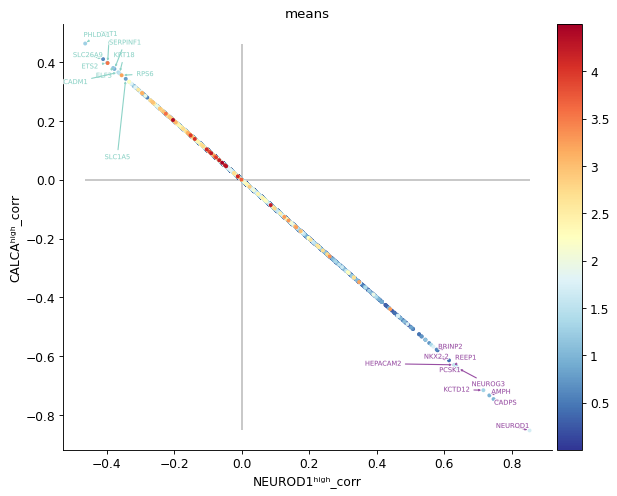

In [48]:
NEUROD1_genes = list(NEUROD1_df.index[:10])
CALCA_genes = list(CALCA_df.index[:10])

genes_oi = {
    "NEUROD1ʰⁱᵍʰ": NEUROD1_genes,
    "CALCAʰⁱᵍʰ": CALCA_genes
}

# visualize in a scatter plot
g.plot_lineage_drivers_correlation(
    lineage_x="NEUROD1ʰⁱᵍʰ",
    lineage_y="CALCAʰⁱᵍʰ",
    adjust_text=True,
    gene_sets=genes_oi,
    color='means',
    legend_loc="none",
    figsize=(7,7),
    fontsize=6,
    size=50,
    save='ScatterPlot_NEexp_lineage_drivers'
)

Adjusting text position
    Finish (0:00:07)


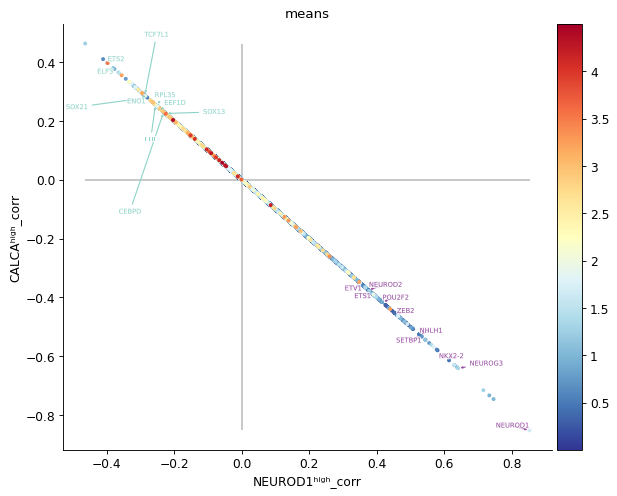

In [49]:
NEUROD1_genes = list(NEUROD1_df_TFs.index[:10])
CALCA_genes = list(CALCA_df_TFs.index[:10])

genes_oi = {
    "NEUROD1ʰⁱᵍʰ": NEUROD1_genes,
    "CALCAʰⁱᵍʰ": CALCA_genes
}

# visualize in a scatter plot
g.plot_lineage_drivers_correlation(
    lineage_x="NEUROD1ʰⁱᵍʰ",
    lineage_y="CALCAʰⁱᵍʰ",
    adjust_text=True,
    gene_sets=genes_oi,
    color='means',
    legend_loc="none",
    figsize=(7,7),
    fontsize=6,
    size=50,
    save='ScatterPlot_NEexp_lineage_drivers_TFs.pdf'
)

# CellRank - Velocity Kernel - BACKWARD

In [140]:
vk_bwd = cr.kernels.VelocityKernel(adata,backward=True)

In [141]:
vk_bwd.compute_transition_matrix(backward_mode='transpose')

Computing transition matrix using `'deterministic'` model


  0%|          | 0/842 [00:00<?, ?cell/s]

Using `softmax_scale=10.4513`


  0%|          | 0/842 [00:00<?, ?cell/s]

    Finish (0:00:01)


~VelocityKernel[n=842, model='deterministic', similarity='correlation', softmax_scale=10.451, bwd_mode='transpose']

Projecting transition matrix onto `draw_graph_fa`
Adding `adata.obsm['T_bwd_draw_graph_fa']`
    Finish (0:00:00)
figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file ./figures/scvelo_cellrank_vk_NEexp_BACKWARDprojection_fdl.png


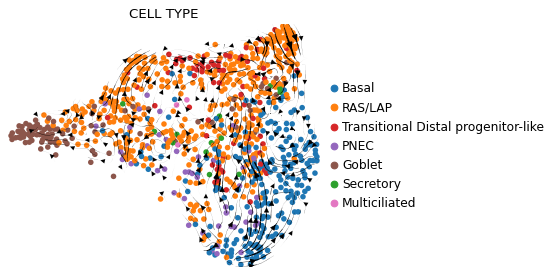

Simulating `100` random walks of maximum length `200`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks


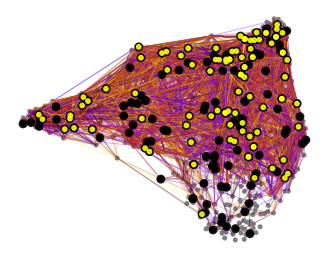

In [143]:
vk_bwd.plot_projection(basis='draw_graph_fa', color=['CELL_TYPE'], legend_loc='right margin',
                   size=100, alpha=1,save='cellrank_vk_NEexp_BACKWARDprojection_fdl')
vk_bwd.plot_random_walks(basis="draw_graph_fa",start_ixs=None, max_iter=200, seed=0,save='cellrank_vk_NEexp_BACKWARDrandomwalk_fdl')

In [144]:
vk_bwd.write_to_adata()
adata.write('./data/NEexp_cellrank_vk.h5ad')
adata

AnnData object with n_obs × n_vars = 842 × 21494
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'n_counts', 'velocity_self_transition', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'init_states_fwd', 'init_states_fwd_probs'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'CELL_TYPE_colors', 'Media_colors', 'Patient ID_colors', 'Sample ID_colors', 'draw_graph', '

In [145]:
vk_bwd = cr.kernels.VelocityKernel.from_adata(adata, key="T_bwd")

In [146]:
from cellrank.estimators import GPCCA

In [147]:
g = cr.estimators.GPCCA(vk_bwd)
print(g)

GPCCA[kernel=~VelocityKernel[n=842], initial_states=None, terminal_states=None]


Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[4, 8, 15, 18, 20]`
Adding `adata.uns['eigendecomposition_bwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:20)


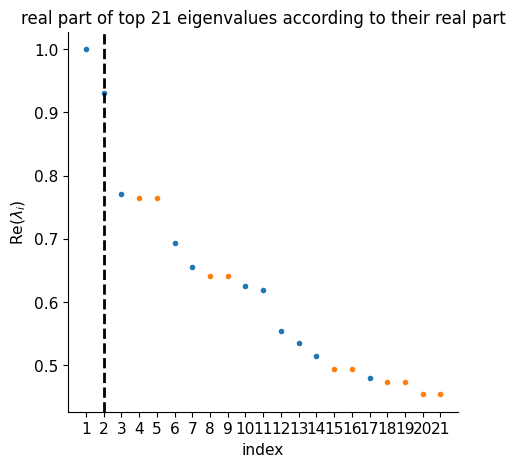

In [148]:
g.compute_schur(method='brandts')
g.plot_spectrum(real_only=True)

In [149]:
g.fit(n_cells=15, cluster_key='CELL_TYPE', n_states=2)

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_bwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:09)
Computing `2` macrostates


Using pre-computed Schur decomposition


Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


GPCCA[kernel=~VelocityKernel[n=842], initial_states=None, terminal_states=None]

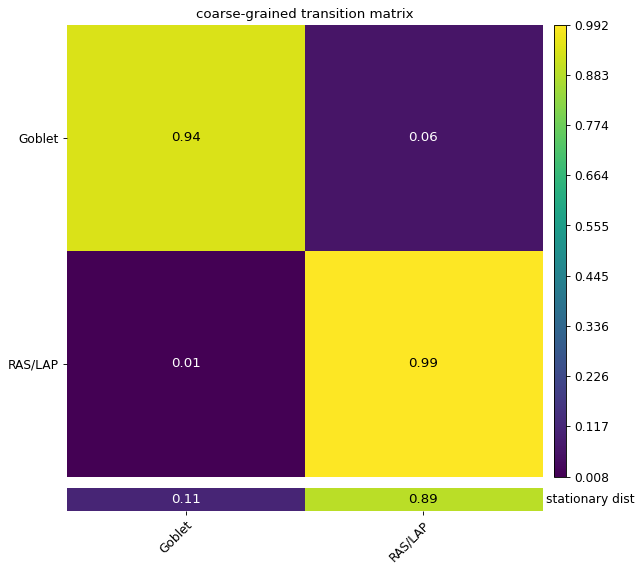

In [150]:
g.plot_coarse_T(save='cellrank_vk_NEexp_BACKWARD_Tmatrix')

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_draw_graph_NEexp_BACKWARD_macrostates.pdf


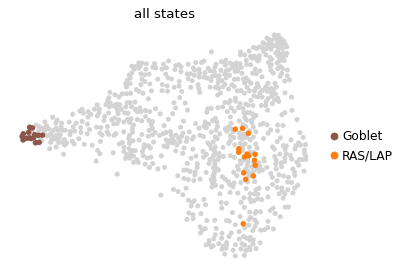

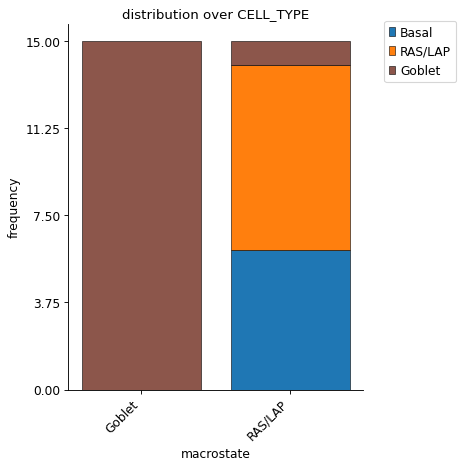

In [151]:
g.plot_macrostates(which="all",basis=["draw_graph_fa"], discrete=True, 
                   legend_loc="right", s=100,save='draw_graph_NEexp_BACKWARD_macrostates')
g.plot_macrostate_composition(key="CELL_TYPE", figsize=(6, 6),save='cellrank_NEexp_BACKWARD_macrostates_distr')

In [152]:
g.predict_terminal_states()

Adding `adata.obs['term_states_bwd']`
       `adata.obs['term_states_bwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


GPCCA[kernel=~VelocityKernel[n=842], initial_states=None, terminal_states=['RAS/LAP']]

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_all_intialstates_draw_graph.pdf


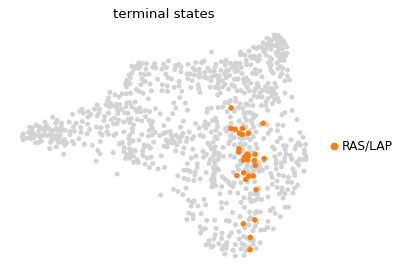

In [153]:
g.plot_macrostates(which="terminal",basis=["draw_graph_fa"], legend_loc="right", s=100, 
                   save='NEexp_all_intialstates_draw_graph')

Adding `adata.obs['term_states_bwd']`
       `adata.obs['term_states_bwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_stability_intialstates_draw_graph.pdf


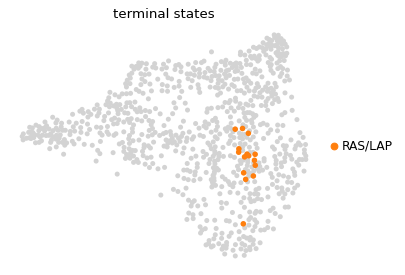

In [154]:
g.predict_terminal_states(method='stability', n_cells=15, allow_overlap=True)
g.plot_macrostates(which="terminal",basis=["draw_graph_fa"], legend_loc="right", s=100,
                   save='NEexp_stability_intialstates_draw_graph')

Adding `adata.obs['term_states_bwd']`
       `adata.obs['term_states_bwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ./figures/scvelo_NEexp_n1_intialstates_draw_graph.pdf


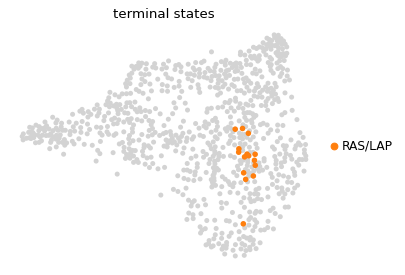

In [155]:
g.predict_terminal_states(method='top_n',n_states=1, n_cells=15, allow_overlap=True)
g.plot_macrostates(which="terminal",basis=["draw_graph_fa"], legend_loc="right", s=100,
                   save='NEexp_n1_intialstates_draw_graph')

In [65]:
adata

AnnData object with n_obs × n_vars = 466 × 19819
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'Cluster', 'n_counts', 'velocity_self_transition', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'init_states_fwd', 'init_states_fwd_probs', 'clusters_gradients', 'fate_probabilities_NEUROD1ʰⁱᵍʰ', 'fate_probabilities_CALCAʰⁱᵍʰ', 'macrostates_bwd', 'term_states_bwd', 'term_states_bwd_probs'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'v

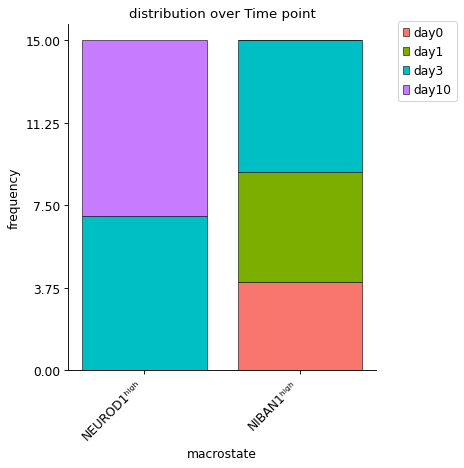

In [66]:
g.plot_macrostate_composition(key="Time point", figsize=(6, 6),save='cellrank_NEexp_BACKWARD_macrostates_timepoint')

In [67]:
g.write('./data/NEexp_cellrank_gpcca_BWD.h5ad', write_adata=True)
adata.write('./data/NEexp_cellrank_vk.h5ad')

Writing `GPCCA[kernel=~VelocityKernel[n=466], initial_states=None, terminal_states=['NIBAN1ʰⁱᵍʰ']]` to `./data/Neuroendocrine_cellrank_gpcca_BWD.h5ad`


In [68]:
adata

AnnData object with n_obs × n_vars = 466 × 19819
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'Cluster', 'n_counts', 'velocity_self_transition', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'init_states_fwd', 'init_states_fwd_probs', 'clusters_gradients', 'fate_probabilities_NEUROD1ʰⁱᵍʰ', 'fate_probabilities_CALCAʰⁱᵍʰ', 'macrostates_bwd', 'term_states_bwd', 'term_states_bwd_probs'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'v

# CellRank - Pseudotime Kernel

In [69]:
adata = sc.read_h5ad('./data/NEexp_cellrank_vk.h5ad')
adata

AnnData object with n_obs × n_vars = 466 × 19819
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'cluster', 'CELL_TYPE', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'Cluster', 'n_counts', 'velocity_self_transition', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'init_states_fwd', 'init_states_fwd_probs', 'clusters_gradients', 'fate_probabilities_NEUROD1ʰⁱᵍʰ', 'fate_probabilities_CALCAʰⁱᵍʰ', 'macrostates_bwd', 'term_states_bwd', 'term_states_bwd_probs'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'v

In [70]:
import palantir
import scanpy as sc
import pandas as pd
import os
# Plotting
import matplotlib
import matplotlib.pyplot as plt
# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning
# Inline plotting
%matplotlib inline 

In [71]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=5)

2026-01-09 02:11:12.364386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-09 02:11:12.364501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-09 02:11:12.366245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-09 02:11:14.429522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [72]:
ms_data = palantir.utils.determine_multiscale_space(adata)

In [73]:
imputed_X = palantir.utils.run_magic_imputation(adata)

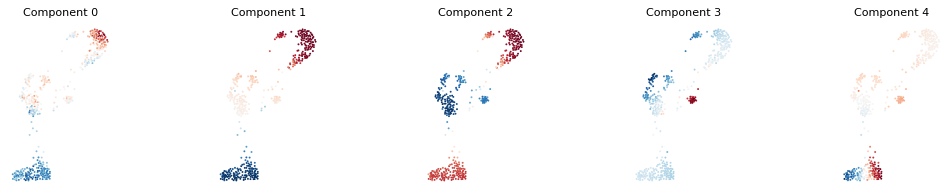

In [74]:
palantir.plot.plot_diffusion_components(adata,embedding_basis="X_draw_graph_fa")
plt.show()

In [75]:
term_states_probs_series = adata.obs['term_states_fwd_probs']
# Sort the series in ascending order
sorted_probs_series = term_states_probs_series.sort_values()
# Print the sorted values
sorted_probs_series.tail(10)

s066.92     0.998571
s005.48     0.998629
s062.31     0.998634
s059.121    0.998825
s062.148    0.999011
s062.71     0.999019
s060.170    0.999379
s031.63     0.999425
s090.97     1.000000
s066.143    1.000000
Name: term_states_fwd_probs, dtype: float64

In [84]:
terminal_states = pd.Series(
    ["CALCAʰⁱᵍʰ","NEUROD1ʰⁱᵍʰ"],
    index=["s066.143","s090.97"])

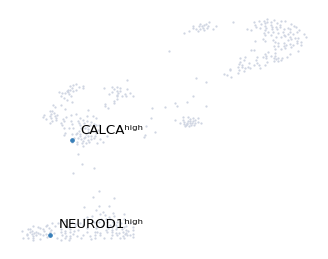

In [85]:
palantir.plot.highlight_cells_on_umap(adata, terminal_states, embedding_basis="X_draw_graph_fa")
plt.show()

In [78]:
init_states_probs_series = adata.obs['term_states_bwd_probs']
# Sort the series in ascending order
sorted_probs_series = init_states_probs_series.sort_values()
# Print the sorted values
sorted_probs_series.tail(10)

s006.159    0.999858
s031.62     0.999885
s092.46     0.999893
s027.131    0.999923
s008.222    0.999929
s061.158    0.999964
s092.101    0.999987
s086.203    0.999993
s026.21     0.999997
s026.49     1.000000
Name: term_states_bwd_probs, dtype: float64

In [82]:
initial_states = pd.Series(
    ["NIBAN1ʰⁱᵍʰ"],
    index=["s026.49"])

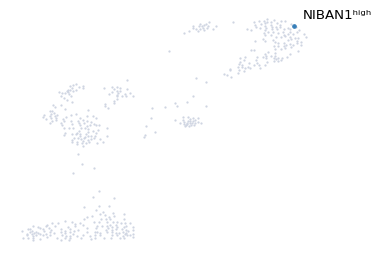

In [83]:
palantir.plot.highlight_cells_on_umap(adata, initial_states, embedding_basis="X_draw_graph_fa")
plt.show()

In [86]:
start_cell = "s026.49"
pr_res = palantir.core.run_palantir(adata, start_cell,terminal_states=terminal_states)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0018006165822347004 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 4.407192881902059 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


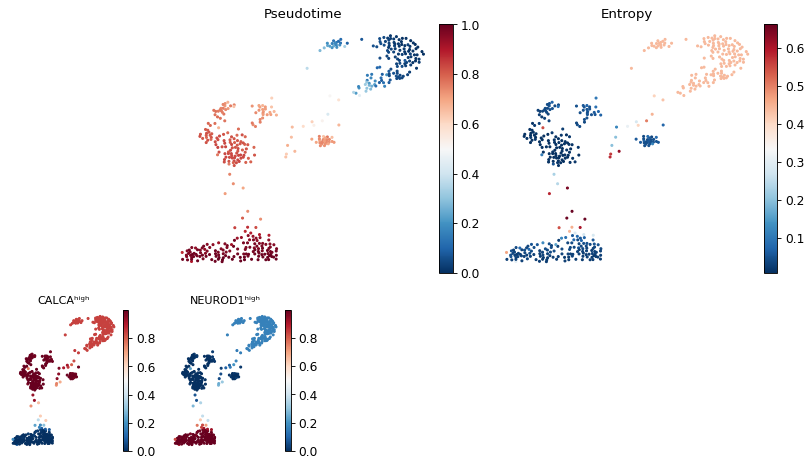

In [87]:
palantir.plot.plot_palantir_results(adata, s=3, embedding_basis="X_draw_graph_fa")
plt.show()

/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/candeli/.conda/envs/noah-py/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


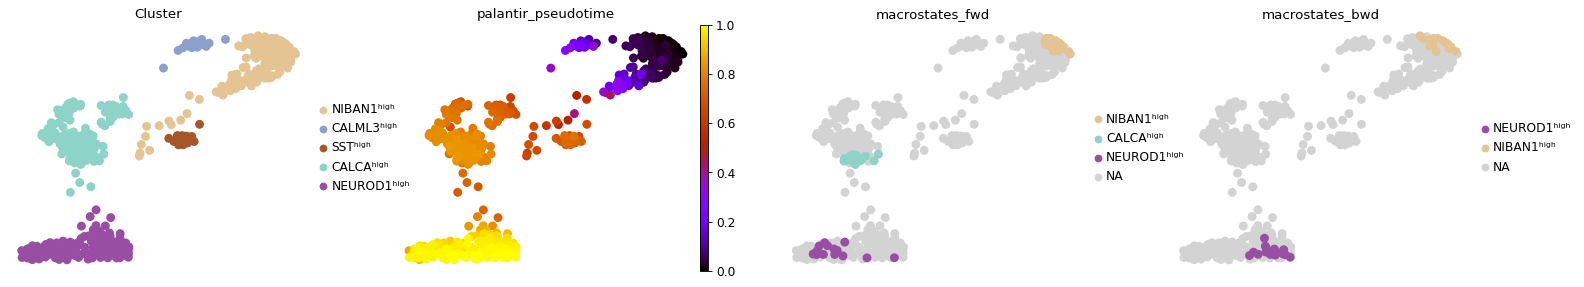

In [88]:
sc.pl.embedding(
    adata,
    basis="X_draw_graph_fa",
    color=["CELL_TYPE","palantir_pseudotime",
          "macrostates_fwd","macrostates_bwd",],
    color_map="gnuplot")

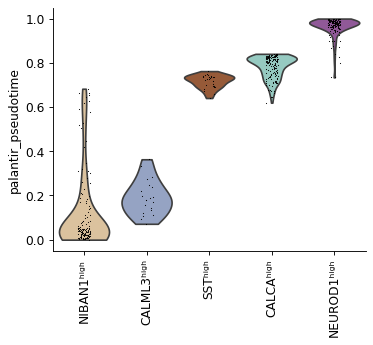

In [89]:
sc.pl.violin(adata, keys=["palantir_pseudotime"], groupby="CELL_TYPE", rotation=90)

In [90]:
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()
print(pk)

Computing transition matrix based on pseudotime


  0%|          | 0/466 [00:00<?, ?cell/s]

    Finish (0:00:00)
PseudotimeKernel[n=466]


Projecting transition matrix onto `draw_graph_fa`
Adding `adata.obsm['T_fwd_draw_graph_fa']`
    Finish (0:00:00)


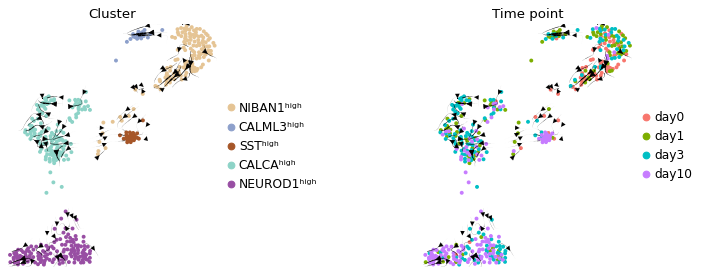

In [91]:
pk.plot_projection(basis="X_draw_graph_fa", color=['CELL_TYPE'CELL_TYPE], legend_loc='right margin',
                   size=50, alpha=1, recompute=True)